In [4]:
import torch
import torchvision  # type: ignore
from torchvision.transforms import v2
import torch.nn as nn
import numpy as np
import seaborn as sns
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [5]:
batch_size_train = 64
batch_size_test = 100

In [6]:
preprocess = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(224),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR100(root='./data', train=True, download=True,
                                   transform=preprocess), batch_size=batch_size_train, shuffle=True
    )
test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR100(root='./data', train=False, download=True,
                                   transform=preprocess), batch_size=batch_size_test, shuffle=False
    )

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


100%|██████████| 169001437/169001437 [00:18<00:00, 9092014.90it/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_1', weights="IMAGENET1K_V1")

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 121MB/s]


In [8]:
#model.classifier._modules["1"] = nn.Conv2d(512, 100, kernel_size=(1, 1))
model.classifier[1].out_channels = 100
model.classifier[0] = nn.BatchNorm2d(512)
model

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [9]:
def train(device, model, train_loader, learning_rate=0.001, epochs=5, model_save_path='best_model.pth'):
    loss_fn = nn.CrossEntropyLoss().to(device)
    for param in model.classifier.parameters():
        param.requires_grad = True
    trainable_params = [p for p in model.parameters() if p.requires_grad==True]
    optimizer = torch.optim.RMSprop(trainable_params, lr=learning_rate)
    history = []
    best_loss = float('inf')

    for epoch in tqdm(range(epochs)):
        epoch_loss = 0.0
        for x, y in train_loader:
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            pred = model(x)

            loss = loss_fn(pred, y)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()

        average_loss = epoch_loss / len(train_loader)
        history.append(average_loss)

        if average_loss < best_loss:
            best_loss = average_loss
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved with loss {best_loss} at epoch {epoch + 1}')

        print(f'Epoch {epoch + 1}, Loss: {average_loss}')

    plt.plot(range(0, epochs), history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss per Epoch')
    plt.show()

In [10]:
def test(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    num_classes = 100
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = correct / total
    print(f"Accuracy on the test set: {accuracy:.2%}")

    cm = confusion_matrix(all_labels, all_predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(20, 18))
    sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='Blues', cbar=True)

    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.title('Confusion Matrix (Normalized)', fontsize=16)

    plt.xticks(np.arange(num_classes) + 0.5, labels=np.arange(num_classes), rotation=90, fontsize=10)
    plt.yticks(np.arange(num_classes) + 0.5, labels=np.arange(num_classes), rotation=0, fontsize=10)

    plt.tight_layout()
    plt.show()

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for param in model.parameters():
    param.requires_grad = False
model = model.to(device)

device(type='cuda')

In [16]:
model.load_state_dict(torch.load('best_model.pth'))

<ipython-input-16-97ca0473330f>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

 10%|█         | 1/10 [02:14<20:09, 134.41s/it]

Model saved with loss 1.1902476607076347 at epoch 1
Epoch 1, Loss: 1.1902476607076347


 20%|██        | 2/10 [04:28<17:52, 134.07s/it]

Model saved with loss 1.1263909070845455 at epoch 2
Epoch 2, Loss: 1.1263909070845455


 30%|███       | 3/10 [06:43<15:43, 134.76s/it]

Model saved with loss 1.0887380091430585 at epoch 3
Epoch 3, Loss: 1.0887380091430585


 40%|████      | 4/10 [08:59<13:31, 135.28s/it]

Model saved with loss 1.0576206265050736 at epoch 4
Epoch 4, Loss: 1.0576206265050736


 50%|█████     | 5/10 [11:15<11:16, 135.26s/it]

Model saved with loss 1.0298941340440375 at epoch 5
Epoch 5, Loss: 1.0298941340440375


 60%|██████    | 6/10 [13:32<09:04, 136.08s/it]

Model saved with loss 1.006856966430269 at epoch 6
Epoch 6, Loss: 1.006856966430269


 70%|███████   | 7/10 [15:48<06:48, 136.11s/it]

Model saved with loss 0.98687768977164 at epoch 7
Epoch 7, Loss: 0.98687768977164


 80%|████████  | 8/10 [18:05<04:32, 136.25s/it]

Model saved with loss 0.965974318325672 at epoch 8
Epoch 8, Loss: 0.965974318325672


 90%|█████████ | 9/10 [20:21<02:16, 136.16s/it]

Model saved with loss 0.9494825774598914 at epoch 9
Epoch 9, Loss: 0.9494825774598914


100%|██████████| 10/10 [22:32<00:00, 135.29s/it]

Model saved with loss 0.9326160199501935 at epoch 10
Epoch 10, Loss: 0.9326160199501935


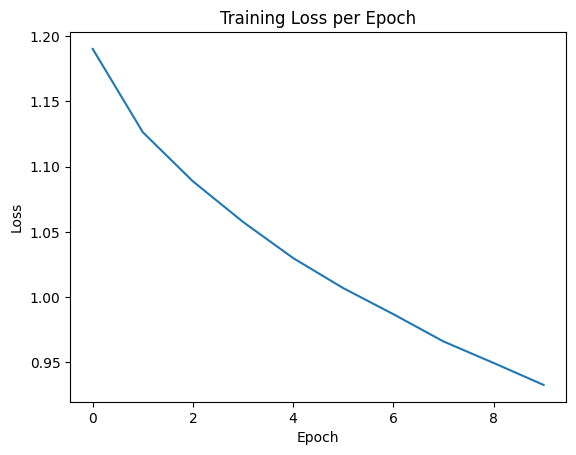

In [17]:
train(device, model, train_loader, learning_rate=10e-4, epochs=10)

Accuracy on the test set: 62.99%


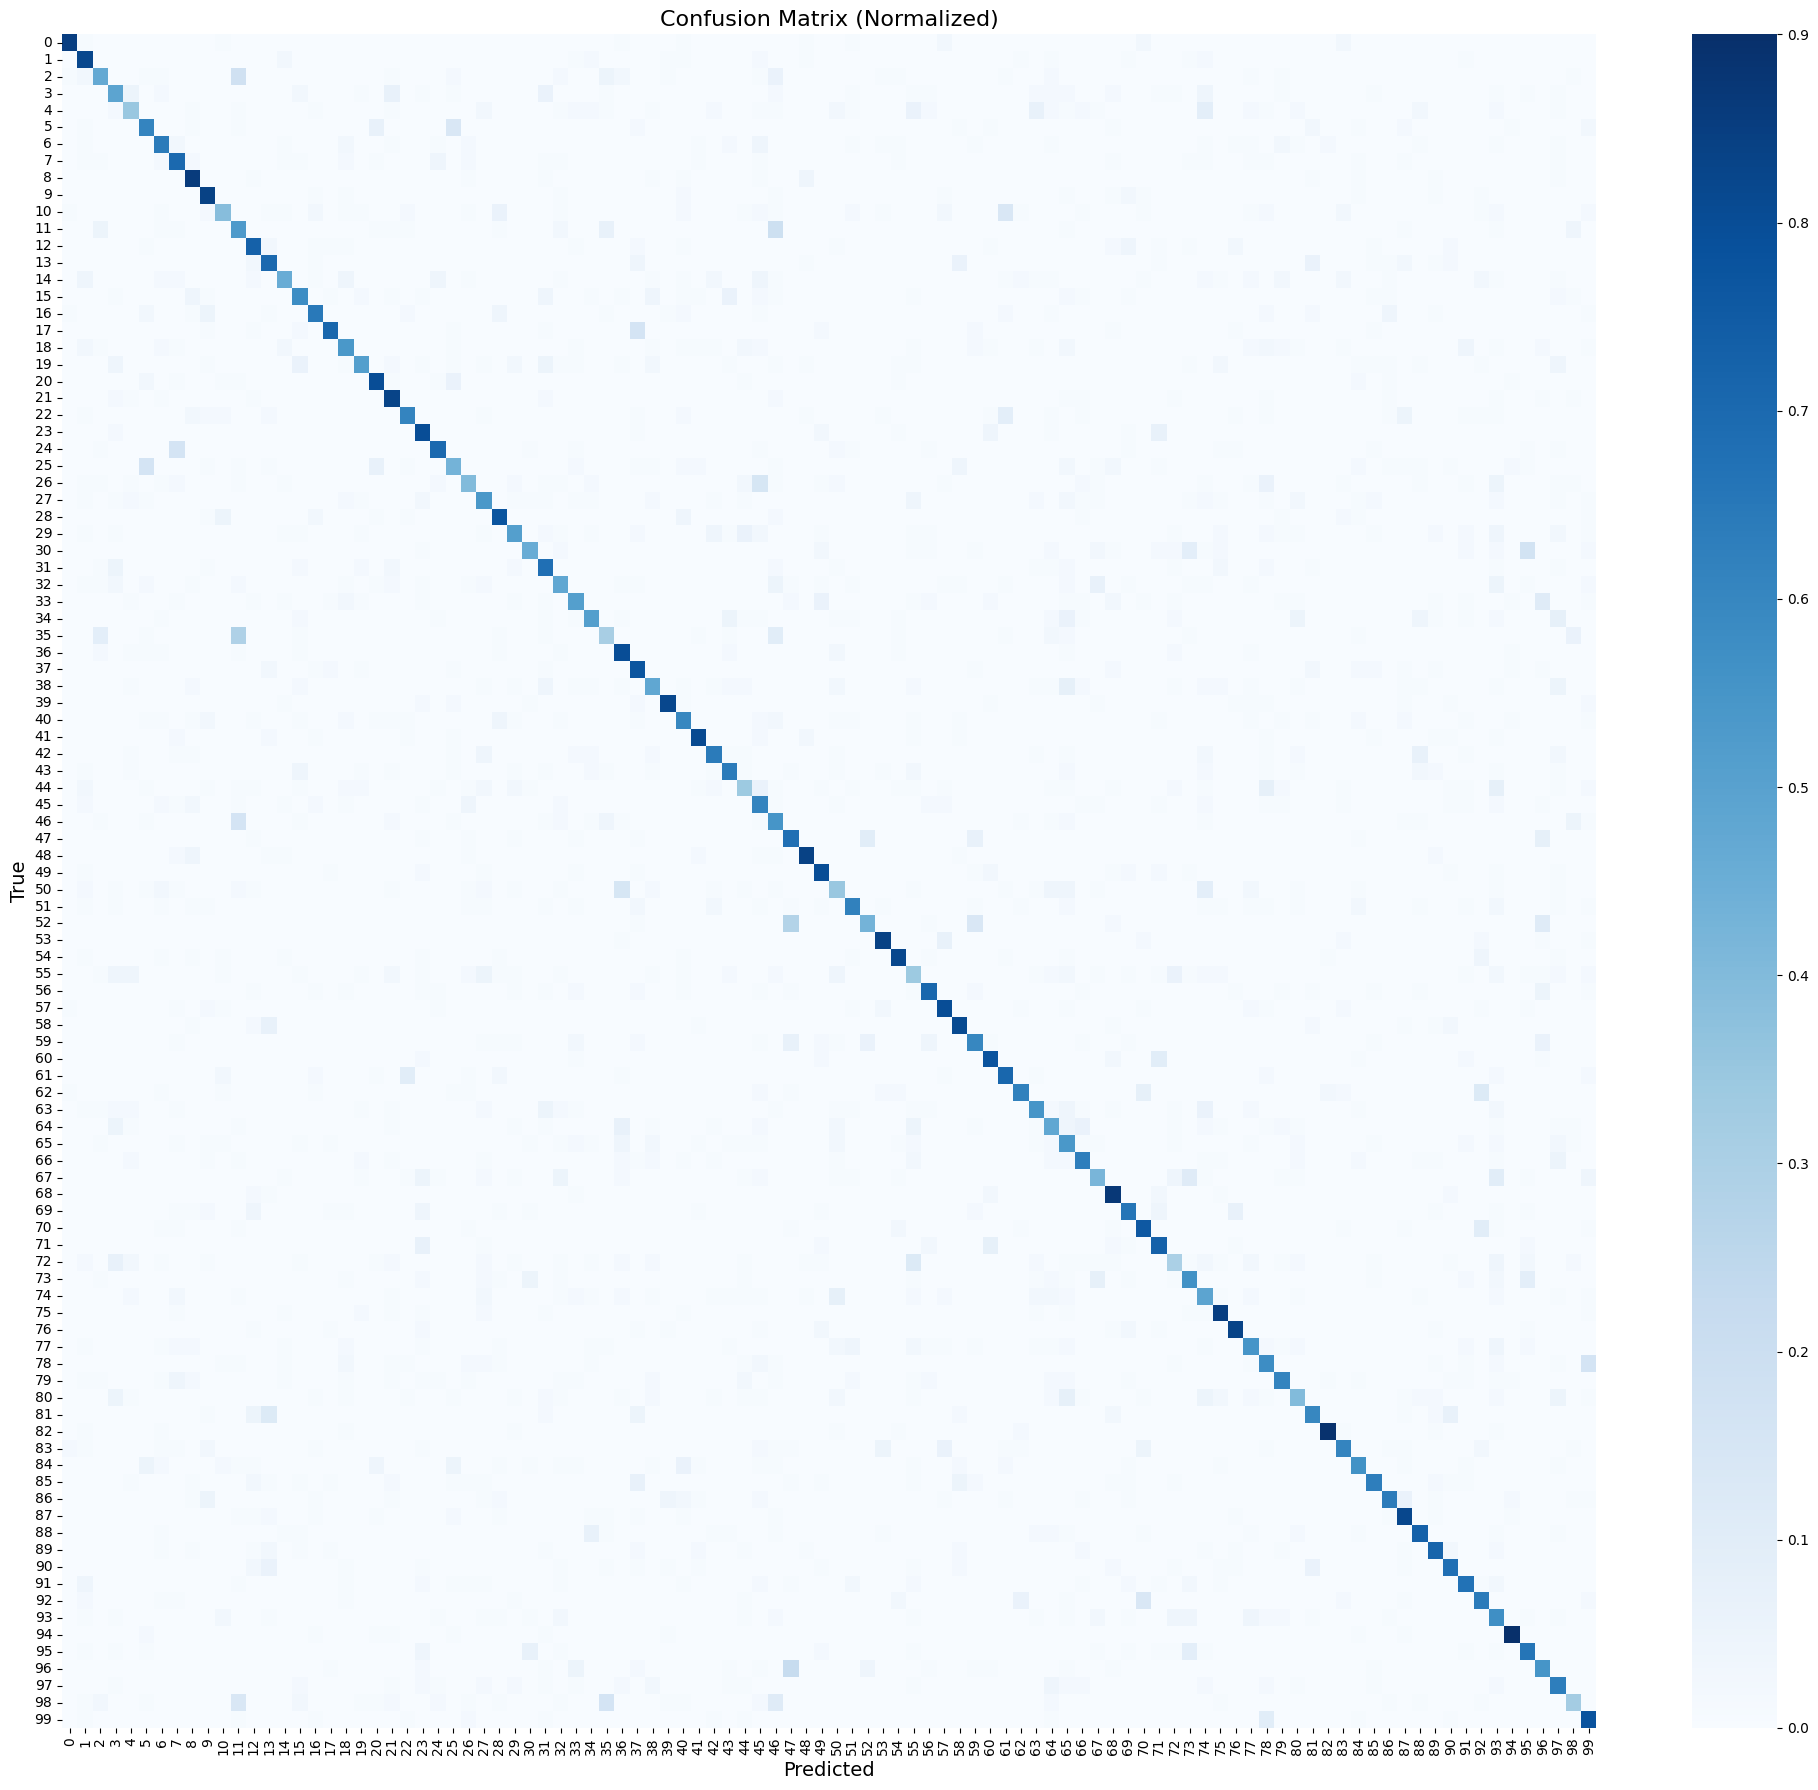

In [18]:
test(model, device, test_loader)

In [19]:
def validate(model, device, test_loader):
    model.eval()
    with torch.no_grad():
        dataset = test_loader.dataset
        random_index = np.random.randint(0, len(dataset))
        single_example = dataset[random_index]
        images, labels = single_example[0], single_example[1]
        images = images.unsqueeze(0).to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        print(f"Предсказано: {predicted.item()}, Реально: {labels}")


In [20]:
dataset = test_loader.dataset
random_index = int(np.random.random()*len(dataset))
single_example = dataset[random_index]

In [22]:
validate(model, device, test_loader)

Предсказано: 27, Реально: 27
